In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

## 1. Data Generation

In [2]:
def set_of_data(n):
    s=[]
    for _ in range(n):
        point=np.array([np.random.randn(),np.random.randn(),np.random.randn()])
        s.append(1/( np.linalg.norm(point) ) * point)
    return np.array(s)

data=set_of_data(5000)

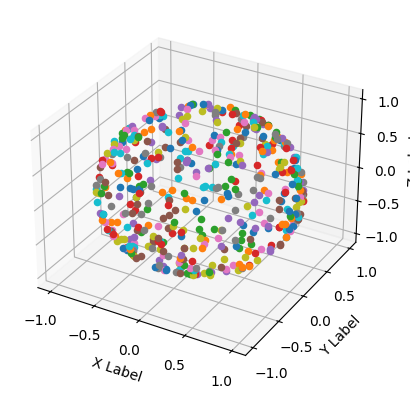

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for (x,y,z) in data[:500]:
    ax.scatter(x, y, z, marker="o")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

(100, 3)


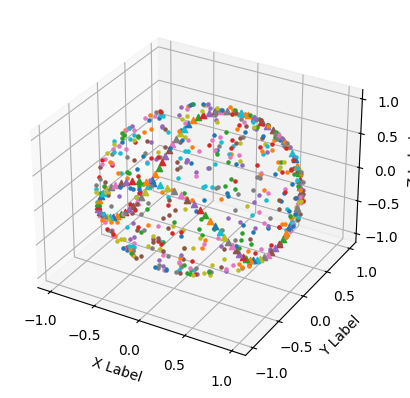

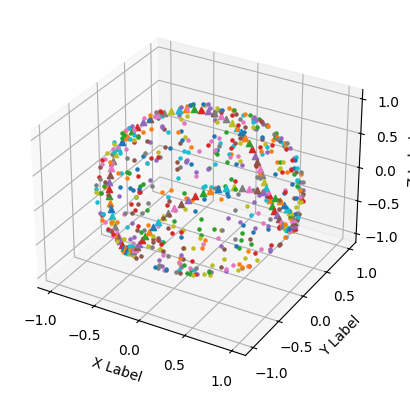

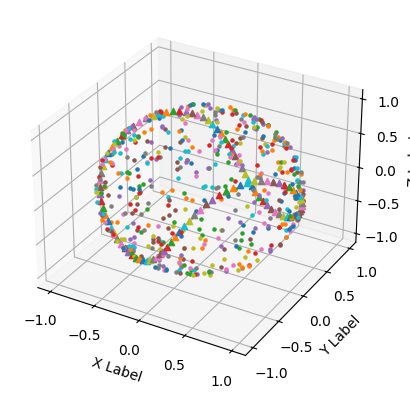

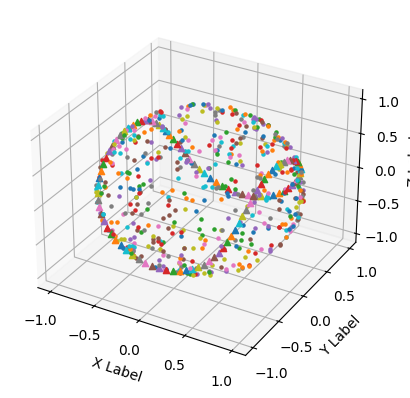

In [4]:
n=100
a=9/10
b=1/10

T=np.linspace(0,2*np.pi,n)
X=a * np.sin(T) + b * np.sin(3*T)
Y=a * np.cos(T) - b * np.cos(3*T)
Z= np.sqrt(4*a*b) * np.cos(2*T)

Sewing=np.array([X,Y,Z]).T
print(np.shape(Sewing))

def plot_baseball(phase):
    fig = plt.figure()

    ax=fig.add_subplot(projection='3d')

    for i in range(n):
        ax.scatter(np.cos(phase)*X[i]-np.sin(phase)*Y[i], np.sin(phase)*X[i]+np.cos(phase)*Y[i], Z[i], marker='^')

    for (x,y,z) in data[:500]:
        ax.scatter(x, y, z, marker=".")


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

plot_baseball(0)
plot_baseball(np.pi/4)
plot_baseball(np.pi/3)
plot_baseball(np.pi/2)


plt.show()

# 1.1 Assign labels

In [5]:
Label=[]

for (x,y,z) in data:
    x1=np.array((x,y,z))
    x2=np.array([(x,y,(1-1/100) * z + 1/100)])
    x2 = x2 / np.linalg.norm(x2)
    distances1 = np.linalg.norm(Sewing - x1, axis=1)
    distances2 = np.linalg.norm(Sewing - x2, axis=1)
    min1=np.min(distances1)
    min2=np.min(distances2)
    if min1<min2:
        Label.append(1)
    elif min1>min2:
        Label.append(0)
    else:
        print('Method is actually unsafe')
        Label.append(1)

Label=np.array(Label)


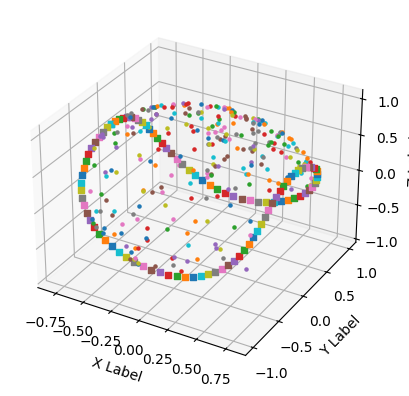

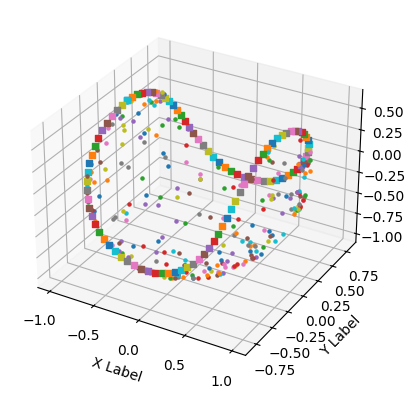

In [6]:
phase = np.pi*1/2
n=500

X=data[:,0]
Y=data[:,1]
Z=data[:,2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for (x,y,z) in Sewing:
    ax.scatter(np.cos(phase)*x-np.sin(phase)*y, np.sin(phase)*x+np.cos(phase)*y, z, marker=',')


for i in range(n):
    if Label[i]==1:
        ax.scatter(np.cos(phase)*X[i]-np.sin(phase)*Y[i], np.sin(phase)*X[i]+np.cos(phase)*Y[i], Z[i], marker='.')
    #else:
        #ax.scatter(np.cos(phase)*X[i]-np.sin(phase)*Y[i], np.sin(phase)*X[i]+np.cos(phase)*Y[i], Z[i], marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for (x,y,z) in Sewing:
    ax.scatter(np.cos(phase)*x-np.sin(phase)*y, np.sin(phase)*x+np.cos(phase)*y, z, marker=',')


for i in range(n):
    if Label[i]==0:
        ax.scatter(np.cos(phase)*X[i]-np.sin(phase)*Y[i], np.sin(phase)*X[i]+np.cos(phase)*Y[i], Z[i], marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

plt.show()

In [7]:
Data = torch.from_numpy(data).type(torch.float)
Y = torch.from_numpy(Label).type(torch.float)

X_train,y_train=Data[:4000],Y[:4000]
X_test,y_test=Data[4000:],Y[4000:]


# View the first five samples
Data[:5], Y[:5],X_train[-1],X_test[0]

(tensor([[-0.8226,  0.1573, -0.5465],
         [-0.6866,  0.4283, -0.5875],
         [ 0.6562, -0.4930,  0.5713],
         [-0.4896, -0.5660, -0.6633],
         [ 0.8663, -0.4882,  0.1058]]),
 tensor([1., 0., 1., 0., 1.]),
 tensor([ 0.2618,  0.9116, -0.3169]),
 tensor([-0.3036,  0.6910, -0.6560]))

## Neural Network

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
input=3
hl1=3
hl2=3
output=1

model = nn.Sequential(
    nn.Linear(input, hl1),
    nn.Sigmoid(),
    nn.Linear(hl1, hl2),
    nn.Sigmoid(),
    nn.Linear(hl2,output)
).to(device)

model_2D = nn.Sequential(
    nn.Linear(input, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.5)

optimizer_2D = torch.optim.SGD(model_2D.parameters(), 
                            lr=0.1)


/home/paul/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [11]:
# Fit the model
epochs = 10000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def training(model,optimizer,epochs = 10000):
# Put all data on target device

  for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

In [12]:
training(model,optimizer)

Epoch: 0 | Loss: 0.69564, Accuracy: 50.02% | Test Loss: 0.69507, Test Accuracy: 50.50%
Epoch: 100 | Loss: 0.69341, Accuracy: 29.40% | Test Loss: 0.69339, Test Accuracy: 29.40%
Epoch: 200 | Loss: 0.69229, Accuracy: 74.48% | Test Loss: 0.69230, Test Accuracy: 72.40%
Epoch: 300 | Loss: 0.68950, Accuracy: 75.88% | Test Loss: 0.68953, Test Accuracy: 74.90%
Epoch: 400 | Loss: 0.67451, Accuracy: 77.35% | Test Loss: 0.67466, Test Accuracy: 76.90%
Epoch: 500 | Loss: 0.55380, Accuracy: 78.03% | Test Loss: 0.55591, Test Accuracy: 79.10%
Epoch: 600 | Loss: 0.43932, Accuracy: 78.15% | Test Loss: 0.45136, Test Accuracy: 79.50%
Epoch: 700 | Loss: 0.43144, Accuracy: 78.12% | Test Loss: 0.44661, Test Accuracy: 79.40%
Epoch: 800 | Loss: 0.42949, Accuracy: 78.17% | Test Loss: 0.44535, Test Accuracy: 79.20%
Epoch: 900 | Loss: 0.42788, Accuracy: 78.15% | Test Loss: 0.44398, Test Accuracy: 79.20%
Epoch: 1000 | Loss: 0.42635, Accuracy: 78.20% | Test Loss: 0.44261, Test Accuracy: 79.20%
Epoch: 1100 | Loss: 0.

In [13]:
training(model_2D,optimizer_2D)

Epoch: 0 | Loss: 0.69758, Accuracy: 51.58% | Test Loss: 0.69691, Test Accuracy: 50.70%
Epoch: 100 | Loss: 0.68045, Accuracy: 55.70% | Test Loss: 0.68088, Test Accuracy: 55.00%
Epoch: 200 | Loss: 0.60745, Accuracy: 70.78% | Test Loss: 0.60940, Test Accuracy: 68.60%
Epoch: 300 | Loss: 0.48453, Accuracy: 78.90% | Test Loss: 0.49095, Test Accuracy: 79.40%
Epoch: 400 | Loss: 0.42731, Accuracy: 80.25% | Test Loss: 0.43609, Test Accuracy: 81.10%
Epoch: 500 | Loss: 0.39524, Accuracy: 81.17% | Test Loss: 0.40357, Test Accuracy: 81.60%
Epoch: 600 | Loss: 0.35912, Accuracy: 83.00% | Test Loss: 0.36748, Test Accuracy: 82.20%
Epoch: 700 | Loss: 0.31299, Accuracy: 88.15% | Test Loss: 0.32273, Test Accuracy: 86.40%
Epoch: 800 | Loss: 0.27008, Accuracy: 90.75% | Test Loss: 0.28017, Test Accuracy: 89.00%
Epoch: 900 | Loss: 0.23682, Accuracy: 91.88% | Test Loss: 0.24571, Test Accuracy: 90.60%
Epoch: 1000 | Loss: 0.21319, Accuracy: 92.53% | Test Loss: 0.22040, Test Accuracy: 91.00%
Epoch: 1100 | Loss: 0.

## Visualising the manifolds

In [14]:
model_0 = nn.Sequential(
).to(device)

model_1 = nn.Sequential(
    model[0],  # First Linear layer
).to(device)

model_12 = nn.Sequential(
    model[0],  # First Linear layer
    model[1]   # First ReLU layer
).to(device)

model_123 = nn.Sequential(
    model[0],  # First Linear layer
    model[1],  # First ReLU layer
    model[2]   # Second Linear layer
).to(device)

model_1234 = nn.Sequential(
    model[0],  # First Linear layer
    model[1],  # First ReLU layer
    model[2],  # Second Linear layer
    model[3]   # Second ReLU layer
).to(device)

In [15]:
import plotly.graph_objects as go
import numpy as np
import torch

def plot_model_act(mod, X):
    with torch.no_grad():
        c=y_train
        X_mod = mod(X).detach().cpu().numpy()

    # Create Plotly figure
    fig = go.Figure(data=[go.Scatter3d(
        x=X_mod[:, 0],
        y=X_mod[:, 1],
        z=X_mod[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=c,  # Color by predictions
            colorscale='Viridis',  # Choose a colorscale
            opacity=0.8,
            colorbar=dict(title='Predictions')
        ),
        text=[f'Point {i}' for i in range(len(X_mod))]  # Labels for each point
    )])

    # Set labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='3D Scatter Plot with Predictions and Labels'
    )

    # Show the plot
    fig.show()


In [16]:
plot_model_act(model_0, X_train)

In [17]:
plot_model_act(model_1,X_train)

In [18]:
plot_model_act(model_12,X_train)

In [19]:
plot_model_act(model_123,X_train)

In [20]:
plot_model_act(model_1234,X_train)

In [21]:
def plot_model_act_2(mod, X, elev=30, azim=30):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    with torch.no_grad():
        c = torch.round(torch.sigmoid(model(X.squeeze()))).cpu().numpy()
        X_mod = mod(X).detach().cpu().numpy()

    # Create meshgrid for surface plot
    x_min, x_max = X_mod[:, 0].min() - 1, X_mod[:, 0].max() + 1
    y_min, y_max = X_mod[:, 1].min() - 1, X_mod[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    # Calculate corresponding z values using model output
    zz_grid = np.zeros_like(xx, dtype=np.float32)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            grid_point = torch.Tensor([[xx[i, j], yy[i, j], 0]]).to(device)
            zz_grid[i, j] = mod(grid_point).item()  # Use .item() for scalar values only

    # Plot the 3D surface
    ax.plot_surface(xx, yy, zz_grid, cmap=plt.cm.viridis, edgecolor='k')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    # Set the perspective using elevation and azimuth
    ax.view_init(elev=elev, azim=azim)

    plt.show()

# Example usage
# X_train_np = X_train.cpu().numpy()
# plot_model_act(model[2], X_train, np.pi / 3, elev=30, azim=30)